<a href="https://colab.research.google.com/github/roberthsu2003/machine_learning/blob/main/%E8%96%88%E8%90%83%E5%BC%8F%E5%AD%B8%E7%BF%92/Stacking%E7%AF%84%E4%BE%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install wget

In [2]:
#下載字型
import wget
wget.download("https://github.com/roberthsu2003/machine_learning/raw/refs/heads/main/source_data/ChineseFont.ttf")

'ChineseFont.ttf'

中文字型已設定為 'ChineseFont'
Pima 印第安人糖尿病數據集前5行:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

數據集維度: (768, 9)

處理後的訓練數據維度: (537, 8)
處理後的測試數據維度: (231, 8)

--- 基礎學習器效能 ---
邏輯回歸 (基礎) - 準確率: 0.7532, ROC-AUC: 0.8372
決策樹 (基礎) - 準確率: 0.7143, ROC-AUC: 0.7462
支持向量機 (基礎) - 準確率: 0.7446, ROC-AUC: 0.8282
K-近鄰 (基礎) - 準確率: 0.7403, ROC-AUC: 0.8075

--- 堆疊分類器 (Stackin

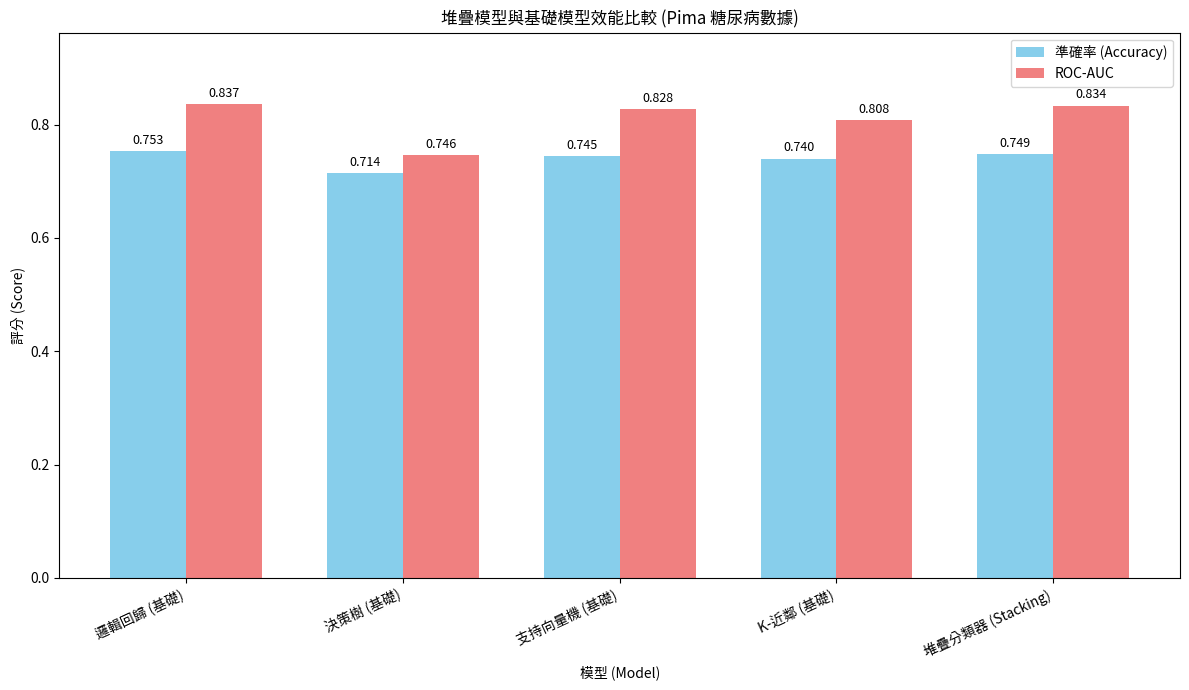

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# 基礎學習器
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # 新增一個基礎學習器範例

# Stacking 分類器
from sklearn.ensemble import StackingClassifier

# 評估指標
from sklearn.metrics import accuracy_score, roc_auc_score

# 繪圖相關
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# --- 中文字型設定 ---
# 假設您已在筆記本前面儲存格成功下載並使 fontManager 知道 "ChineseFont.ttf"
try:
    fontManager.addfont("ChineseFont.ttf")
    mpl.rc('font', family="ChineseFont")
    print("中文字型已設定為 'ChineseFont'")
except Exception as e:
    print(f"中文字型設定失敗: {e}。圖表可能無法正確顯示中文。")
    pass

# --- 1. 數據載入 (Pima Indians Diabetes Dataset) ---
data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
    'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
]
data = pd.read_csv(data_url, header=None, names=column_names)

print("Pima 印第安人糖尿病數據集前5行:")
print(data.head())
print(f"\n數據集維度: {data.shape}")

# --- 2. 數據預處理 ---
X_raw = data.drop(columns=['Outcome'])
y = data['Outcome']

# 處理特徵中的零值
cols_to_impute_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
X_imputed = X_raw.copy() # 創建副本以避免修改原始X_raw
for col in cols_to_impute_zero:
    mean_val = X_imputed[col][X_imputed[col] != 0].mean()
    X_imputed[col] = X_imputed[col].replace(0, mean_val)

numerical_features = X_imputed.columns.tolist()

# 創建預處理器 (僅標準化，因為所有特徵都是數值型)
preprocessor = StandardScaler()

# 分割訓練和測試數據
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42, stratify=y)

# 對訓練數據進行擬合和轉換，對測試數據僅進行轉換
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

print(f"\n處理後的訓練數據維度: {X_train.shape}")
print(f"處理後的測試數據維度: {X_test.shape}")

# --- 3. 模型定義、訓練與評估 ---
model_names_plot = []
accuracies_plot = []
roc_aucs_plot = []

# 3.1 定義基礎學習器 (Base Learners)
base_lr = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
base_dt = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
base_svc = SVC(probability=True, random_state=42, class_weight='balanced') # probability=True for roc_auc
base_knn = KNeighborsClassifier(n_neighbors=5)


# 3.2 訓練並評估基礎學習器 (用於比較)
base_learners_for_comparison = {
    "邏輯回歸 (基礎)": base_lr,
    "決策樹 (基礎)": base_dt,
    "支持向量機 (基礎)": base_svc,
    "K-近鄰 (基礎)": base_knn
}

print("\n--- 基礎學習器效能 ---")
for name, model in base_learners_for_comparison.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0.0 # KNN可能沒有predict_proba

    model_names_plot.append(name)
    accuracies_plot.append(acc)
    roc_aucs_plot.append(roc_auc)
    print(f"{name} - 準確率: {acc:.4f}, ROC-AUC: {roc_auc:.4f}")


# 3.3 定義 Stacking 分類器的基礎學習器列表和元學習器
# 重新實例化模型以確保 StackingClassifier 內部正確處理
estimators = [
    ('lr', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')),
    ('svc', SVC(probability=True, random_state=42, class_weight='balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]
# 元學習器 (Meta-Learner)
meta_learner = LogisticRegression(solver='liblinear', random_state=123, class_weight='balanced')

# 3.4 初始化並訓練 Stacking 分類器
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5 # 交叉驗證用於生成元特徵
)
stacking_clf.fit(X_train, y_train)

# 3.5 評估 Stacking 分類器
stacking_pred = stacking_clf.predict(X_test)
stacking_proba = stacking_clf.predict_proba(X_test)[:, 1]
stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_roc_auc = roc_auc_score(y_test, stacking_proba)

model_names_plot.append('堆疊分類器 (Stacking)')
accuracies_plot.append(stacking_accuracy)
roc_aucs_plot.append(stacking_roc_auc)
print(f"\n--- 堆疊分類器 (Stacking) 效能 ---")
print(f"堆疊分類器 (Stacking) - 準確率: {stacking_accuracy:.4f}, ROC-AUC: {stacking_roc_auc:.4f}")


# --- 4. 繪製效能比較圖表 ---
plt.figure(figsize=(max(12, 2 * len(model_names_plot)), 7)) # 根據模型數量動態調整寬度
bar_width = 0.35
index = np.arange(len(model_names_plot))

rects1 = plt.bar(index, accuracies_plot, bar_width, label='準確率 (Accuracy)', color='skyblue')
rects2 = plt.bar(index + bar_width, roc_aucs_plot, bar_width, label='ROC-AUC', color='lightcoral')

plt.xlabel('模型 (Model)')
plt.ylabel('評分 (Score)')
plt.title('堆疊模型與基礎模型效能比較 (Pima 糖尿病數據)')
plt.xticks(index + bar_width / 2, model_names_plot, rotation=25, ha="right")
plt.ylim(0, max(max(accuracies_plot, default=0), max(roc_aucs_plot, default=0)) * 1.15 if accuracies_plot or roc_aucs_plot else 1.05)
plt.legend()

def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

current_ax = plt.gca()
autolabel(rects1, current_ax)
autolabel(rects2, current_ax)

plt.tight_layout()

# --- 5. 儲存並顯示圖表 ---
chart_filename = 'pima_diabetes_stacking_performance_comparison.png'
plt.savefig(chart_filename)
print(f"\n圖表已儲存為: {chart_filename}")
plt.show()


**程式碼說明：**

1. **數據載入與預處理**：
    - 與之前的 Pima 數據範例相同，載入數據、定義欄位名、處理不合理的零值（用平均值填充）、使用 `StandardScaler` 進行特徵標準化。
1. **模型定義**：
    - **基礎學習器 (Base Learners)**：定義了邏輯回歸 (`LogisticRegression`)、決策樹 (`DecisionTreeClassifier`)、支持向量機 (`SVC`) 和 K-近鄰 (`KNeighborsClassifier`) 作為基礎模型。
        - 對於 `SVC`，設定 `probability=True` 以便後續計算 ROC-AUC 分數。
        - 對於分類模型，通常建議使用 `class_weight='balanced'` 來處理潛在的類別不平衡問題。
    - **元學習器 (Meta-Learner)**：使用一個邏輯回歸作為元學習器。
1. **基礎學習器單獨評估**：
    - 在構建 Stacking 模型之前，單獨訓練每個基礎學習器並在測試集上評估其性能（準確率和 ROC-AUC）。這些結果將用於與 Stacking 模型的性能進行比較。
1. **Stacking 分類器**：
    - `estimators` 參數是一個列表，包含元組 `(name, model_instance)`，定義了用於 Stacking 的基礎學習器。**注意**：這裡我們重新實例化了基礎學習器，這是個好習慣，以確保 `StackingClassifier` 內部對它們進行正確的克隆和擬合，而不會受到先前單獨訓練的影響。
    - `final_estimator` 參數是元學習器。
    - `cv=5` 表示使用5折交叉驗證來生成基礎學習器的預測，這些預測將作為元學習器的訓練數據。
1. **訓練與評估**：
    - 分別訓練和評估基礎學習器及 Stacking 分類器。
    - 將所有模型的名稱、準確率和 ROC-AUC 分數儲存在 `model_names_plot`、`accuracies_plot` 和 `roc_aucs_plot` 列表中，以便後續繪圖。
1. **繪圖與儲存**：
    - 使用 `matplotlib` 繪製長條圖，比較所有模型在準確率和 ROC-AUC 上的表現。
    - X 軸標籤進行了輕微旋轉 (`rotation=25, ha="right"`) 以避免因模型名稱較長而導致的重疊。
    - 圖表標題和儲存檔名已更新，以反映這是 Pima 糖尿病數據集的 Stacking 效能比較。
    - 圖表寬度會根據模型數量動態調整。

執行此儲存格後，您將看到各個基礎模型和 Stacking 模型的性能指標輸出，隨後是一個比較它們效能的長條圖，並且該圖表會以 `pima_diabetes_stacking_performance_comparison.png` 的檔名儲存。